[Reference](https://github.com/thushv89/manning_tf2_in_action/blob/master/Ch07/7.2.Transfer_Learning.ipynb)

In [1]:
import tensorflow as tf
#import tensorflow_hub as hub
import requests
print(tf.__version__)
import zipfile
import requests
import os
import time
import pandas as pd
import random
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, AvgPool2D, Dense, Concatenate, Flatten, Lambda, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.losses import CategoricalCrossentropy
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger
import numpy as np
from PIL import Image
import tensorflow.keras.backend as K
import pickle
from tensorflow.keras.models import load_model, Model

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except:
        print("Couldn't set memory_growth")
        pass
    
    
def fix_random_seed(seed):
    """ Setting the random seed of various libraries """
    try:
        np.random.seed(seed)
    except NameError:
        print("Warning: Numpy is not imported. Setting the seed for Numpy failed.")
    try:
        tf.random.set_seed(seed)
    except NameError:
        print("Warning: TensorFlow is not imported. Setting the seed for TensorFlow failed.")
    try:
        random.seed(seed)
    except NameError:
        print("Warning: random module is not imported. Setting the seed for random failed.")

# Fixing the random seed
random_seed=4321
fix_random_seed(random_seed)

2.3.0


In [2]:
import os
import requests
import zipfile

# Retrieve the data
if not os.path.exists(os.path.join('data','tiny-imagenet-200.zip')):
    url = "http://cs231n.stanford.edu/tiny-imagenet-200.zip"
    # Get the file from web
    r = requests.get(url)

    if not os.path.exists('data'):
        os.mkdir('data')
    
    # Write to a file
    with open(os.path.join('data','tiny-imagenet-200.zip'), 'wb') as f:
        f.write(r.content)
else:
    print("The zip file already exists.")
    
if not os.path.exists(os.path.join('data', 'tiny-imagenet-200')):
    with zipfile.ZipFile(os.path.join('data','tiny-imagenet-200.zip'), 'r') as zip_ref:
        zip_ref.extractall('data')
else:
    print("The extracted data already exists")

In [3]:
from functools import partial

def get_test_labels_df(test_labels_path):
    """ Reading the test data labels for all files in the test set as a data frame """
    test_df = pd.read_csv(test_labels_path, sep='\t', index_col=None, header=None)
    test_df = test_df.iloc[:,[0,1]].rename({0:"filename", 1:"class"}, axis=1)
    return test_df


        

def get_train_valid_test_data_generators(batch_size, target_size):
    """ Get the training/validation/testing data generators """
    
    # Defining a data-augmenting image data generator and a standard image data generator
    image_gen_aug = ImageDataGenerator(
        samplewise_center=False, rotation_range=30, width_shift_range=0.2,
        height_shift_range=0.2, brightness_range=(0.5,1.5), shear_range=5, 
        zoom_range=0.2, horizontal_flip=True, fill_mode='reflect', validation_split=0.1
    )
    image_gen = ImageDataGenerator(samplewise_center=False)
    
    # Define a training data generator
    partial_flow_func = partial(
        image_gen_aug.flow_from_directory, 
        directory=os.path.join('data','tiny-imagenet-200', 'train'), 
        target_size=target_size, classes=None,
        class_mode='categorical', batch_size=batch_size, 
        shuffle=True, seed=random_seed)
    
    # Get the training data subset
    train_gen = partial_flow_func(subset='training')
    # Get the validation data subset
    valid_gen = partial_flow_func(subset='validation')    

    # Defining the test data generator
    test_df = get_test_labels_df(os.path.join('data','tiny-imagenet-200',  'val', 'val_annotations.txt'))
    test_gen = image_gen.flow_from_dataframe(
        test_df, directory=os.path.join('data','tiny-imagenet-200',  'val', 'images'), target_size=target_size, classes=None,
        class_mode='categorical', batch_size=batch_size, shuffle=False
    )
    return train_gen, valid_gen, test_gen


def data_gen_augmented_inception_resnet_v2(gen, random_gamma=False, random_occlude=False):
    for x,y in gen: 
        if random_gamma:
            # Gamma correction
            # Doing this in the image process fn doesn't help improve performance
            rand_gamma = np.random.uniform(0.93, 1.06, (x.shape[0],1,1,1))
            x = x**rand_gamma
            
        if random_occlude:
            # Randomly occluding sections in the image
            occ_size = 10
            occ_h, occ_w = np.random.randint(0, x.shape[0]-occ_size), np.random.randint(0, x.shape[0]-occ_size)
            x[::2,occ_h:occ_h+occ_size,occ_w:occ_w+occ_size,:] = np.random.choice([0.,128.,255.])
        
        # https://github.com/tensorflow/tensorflow/blob/2b96f3662bd776e277f86997659e61046b56c315/tensorflow/python/keras/applications/imagenet_utils.py#L181
        x /= 127.5
        x -= 1

        yield x,y
        
        
batch_size = 32
target_size = (224,224)
# Getting the train,valid, test data generators
train_gen, valid_gen, test_gen = get_train_valid_test_data_generators(batch_size, target_size)
# Modifying the data generators to fit the model targets
# We augment data in the training set
train_gen_aux = data_gen_augmented_inception_resnet_v2(train_gen, random_gamma=True, random_occlude=True)
# We do not augment data in the validation/test datasets
valid_gen_aux = data_gen_augmented_inception_resnet_v2(valid_gen)
test_gen_aux = data_gen_augmented_inception_resnet_v2(test_gen)


with open(os.path.join('data','class_indices'), 'wb') as f:
    pickle.dump(train_gen.class_indices, f)

Found 90000 images belonging to 200 classes.
Found 10000 images belonging to 200 classes.
Found 10000 validated image filenames belonging to 200 classes.


In [4]:
def get_steps_per_epoch(n_data, batch_size):
    """ Given the data size and batch size, gives the number of steps to travers the full dataset """
    if n_data%batch_size==0:
        return int(n_data/batch_size)
    else:
        return int(n_data*1.0/batch_size)+1

# Pretrained Inception Resnet v2 network 

In [5]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout

K.clear_session()

def get_inception_resnet_v2_pretrained():
    model = Sequential([
        Input(shape=(224,224,3)),
        InceptionResNetV2(include_top=False, pooling='avg'),
        Dropout(0.4),
        Dense(200, activation='softmax')
    ])

    loss = tf.keras.losses.CategoricalCrossentropy()
    adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(loss=loss, optimizer=adam, metrics=['accuracy'])
    return model 

model = get_inception_resnet_v2_pretrained()
model.summary()

219062272/219055592 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 1536)              54336736  
_________________________________________________________________
dropout (Dropout)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 200)               307400    
Total params: 54,644,136
Trainable params: 54,583,592
Non-trainable params: 60,544
_________________________________________________________________


In [6]:
def get_steps_per_epoch(n_data, batch_size):
    """ Given the data size and batch size, gives the number of steps to travers the full dataset """
    if n_data%batch_size==0:
        return int(n_data/batch_size)
    else:
        return int(n_data*1.0/batch_size)+1

In [7]:
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger

es_callback = EarlyStopping(monitor='val_loss', patience=10)
# csv_logger = CSVLogger(os.path.join('eval','4_eval_resnet_pretrained.log'))
n_epochs=2

lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='auto'
)

history = model.fit(
    train_gen_aux, validation_data=valid_gen_aux, 
    steps_per_epoch=get_steps_per_epoch(int(0.9*(500*200)), batch_size), 
    validation_steps=get_steps_per_epoch(int(0.1*(500*200)), batch_size),
    epochs=n_epochs, callbacks=[es_callback, lr_callback] # csv_logger
)

Epoch 1/2
2813/2813 [==============================] - 2612s 929ms/step - loss: 2.0753 - accuracy: 0.5416 - val_loss: 1.5254 - val_accuracy: 0.6432
Epoch 2/2
2813/2813 [==============================] - 2593s 922ms/step - loss: 1.3711 - accuracy: 0.6673 - val_loss: 1.6509 - val_accuracy: 0.6366


In [8]:
if not os.path.exists('models'):
    os.mkdir("models")
model.save(os.path.join('models', 'inception_resnet_v2.h5'))

In [9]:
K.clear_session()
# Load the model from disk
try: 
    model = load_model(os.path.join('models','inception_resnet_v2.h5'))
except:
    # Sometimes loading the above model result in ValueError: Unknown layer: Functional
    print("Model loading failed. Trying a different method")
    model = get_inception_resnet_v2_pretrained()
    model.load_weights(os.path.join('models','inception_resnet_v2.h5'))

print("Model was successfully loaded")
# Evaluate the model
test_res = model.evaluate(test_gen_aux, steps=get_steps_per_epoch(500*50, batch_size))

# Print the results as a dictionary {<metric name>: <value>}
test_res_dict = dict(zip(model.metrics_names, test_res))
print(test_res_dict)


Model was successfully loaded
782/782 [==============================] - 135s 172ms/step - loss: 1.2057 - accuracy: 0.7213
{'loss': 1.205685019493103, 'accuracy': 0.7213107943534851}


No handles with labels found to put in legend.
No handles with labels found to put in legend.


[]


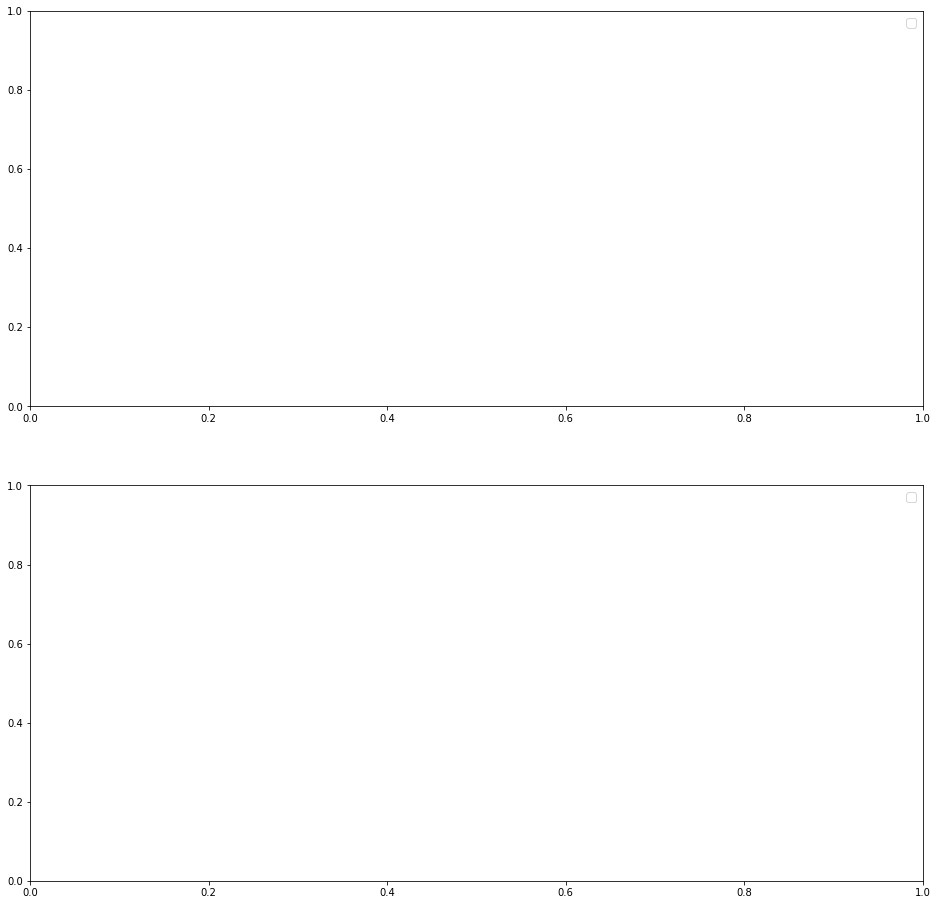

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_metrics(files, metrics, labels=None, linestyles=None, marker_styles=None, colors=None):
    data = {}    
    
    for i, f in enumerate(files):
        df = pd.read_csv(f, header=0, index_col=0)        
        if labels is not None:
            data[labels[i]] = df
        else:
            data[f] = df
            
    fig, axes = plt.subplots(len(metrics), 1, figsize=(16,16))
    
    for m, ax in zip(metrics, axes):        
        met_df = []
        for i, (lbl, df) in enumerate(data.items()):
            train_m, val_m = None, None
            for c in df.columns:
                if m in c and 'val' not in c:
                    train_m = c
                elif m in c and 'val' in c:
                    val_m = c
                    
            if linestyles is not None:
                ax.plot(df.index, df[train_m], linestyle=linestyles[0], color=colors[i], label=lbl+' '+train_m)
                ax.plot(df.index, df[val_m], linestyle=linestyles[1], color=colors[i], label=lbl+' '+val_m)
            else:
                ax.plot(df.index, df[train_m], label=lbl)
                ax.plot(df.index, df[val_m], label=lbl)
        ax.legend(fontsize=13)

if not os.path.exists('eval'):
    os.mkdir('eval') 
files = [os.path.join('eval',f) for f in sorted(os.listdir('eval'))]  
print(files)
metrics = ['accuracy', 'loss']
linestyles= ['-', '--']
labels = ['Inception-mod-data-aug-early-stop', 'Minception', 'Inception-Resnet-v2-pretrained']
colors = ['r', 'g', 'b', 'purple']
plot_metrics(files, metrics, labels, linestyles=linestyles, colors=colors)

In [15]:
K.clear_session()

# Load the model from disk
try: 
    model = load_model(os.path.join('models','inception_resnet_v2.h5'))
except:
    # Sometimes loading the above model result in ValueError: Unknown layer: Functional
    print("Model loading failed. Trying a different method")
    model = get_inception_resnet_v2_pretrained()
    model.load_weights(os.path.join('models','inception_resnet_v2.h5'))

print("Model was successfully loaded")

# Generating predictions
test_gen_aux = data_gen_augmented_inception_resnet_v2(test_gen)
test_preds = model.predict(test_gen_aux, steps=get_steps_per_epoch(500*20, batch_size))
test_preds = np.argmax(test_preds, axis=-1)

Model was successfully loaded


In [16]:
def get_tiny_imagenet_classes(wnids_path, words_path):
    " Get the tiny imagenet class names "
    wnids = pd.read_csv(wnids_path, header=None, squeeze=True)
    words = pd.read_csv(words_path, sep='\t', index_col=0, header=None)
    words_200 = words.loc[wnids].rename({1:'class'}, axis=1)
    words_200.index.name = 'wnid'
    return words_200.reset_index()

def get_best_and_worst_classes(label_df, test_preds, class_indices):
        
    def accuracy(x):
        """ Computing the accuracy """
        return (x["pred_label"]==x["true_label"].iloc[0]).sum()/x.shape[0]
    
    # Create a copy
    test_results = label_df.copy()
    
    # True labels
    test_results["true_label"] = test_results["class"].map(class_indices)
    # Predicted labels are computed earlier
    test_results["pred_label"] = test_preds
    
    # Compute accuracy per class
    per_class_acc = test_results[["class", "true_label", "pred_label"]].groupby("class").apply(
        lambda x: accuracy(x)).sort_values()
    
    # Get label names
    labels = get_tiny_imagenet_classes(wnids_path, words_path).set_index("wnid")["class"]
    per_class_acc = pd.DataFrame(per_class_acc, index=per_class_acc.index, columns=["accuracy"])
    per_class_acc.loc[labels.index, "class_description"] = labels
    
    # Printing the results
    print("Worst performing classes")
    print("="*50)
    print(per_class_acc.head(n=10))
    print("\nBest performing classes")
    print("="*50)
    print(per_class_acc.tail(n=10))
    return {'best': per_class_acc.iloc[-10:], 'worst': per_class_acc.iloc[:10]}

data_dir = os.path.join('data', 'tiny-imagenet-200')
wnids_path = os.path.join(data_dir, 'wnids.txt')
words_path = os.path.join(data_dir, 'words.txt')

test_df = get_test_labels_df(os.path.join('data','tiny-imagenet-200',  'val', 'val_annotations.txt'))
class_indices = test_gen.class_indices
best_and_worst_cls = get_best_and_worst_classes(test_df, test_preds, class_indices)

Worst performing classes
           accuracy class_description
class                                
n03250847       0.0         drumstick
n03670208       0.0   limousine, limo
n03706229       0.0  magnetic compass
n03733131       0.0           maypole
n03763968       0.0  military uniform
n03770439       0.0   miniskirt, mini
n03796401       0.0        moving van
n03804744       0.0              nail
n03814639       0.0        neck brace
n03837869       0.0           obelisk

Best performing classes
           accuracy                     class_description
class                                                    
n01768244      0.02                             trilobite
n09193705      0.04                                   alp
n03970156      0.04             plunger, plumber's helper
n03544143      0.04                             hourglass
n04259630      0.04                              sombrero
n02843684      0.04                             birdhouse
n04486054      0.04           

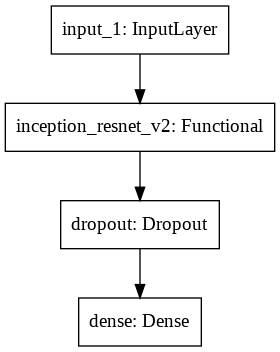

In [17]:
tf.keras.utils.plot_model(model)

In [19]:
# tf.keras.utils.plot_model(model.layers[1], to_file='resnet.png')